In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [87]:
def compute_eff_Sx(Sx,loss_inds,remain_inds):
    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(Ns))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        if len(st_ind)==2:
            inds_new.append(st_ind)
            Stot = np.zeros(N)
            for i_remove in st_ind:
                inds_old.remove(i_remove)
                Stot += Sx_old[i_remove,:]
            Sx_new.append(list(Stot%2)) 
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                Stot = np.zeros(N)
                for i_remove in st_new_ind:
                    Stot += np.array(Sx_new)[i_remove,:]        
                Sx_new[st_new_ind[0]] = list(Stot%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    # print(Sx_new)
    # print(inds_new, inds_old)
    num_Sx_red = len(inds_new)+len(inds_old)
    Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
    Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
    if len(inds_new)>0:
        Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

    # print(Sx_red)
    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
    # print(keep_cols)
    Sx_red = Sx_red[:,keep_cols]

    qubits_to_plot = remain_inds[keep_cols]
    return Sx_red, qubits_to_plot

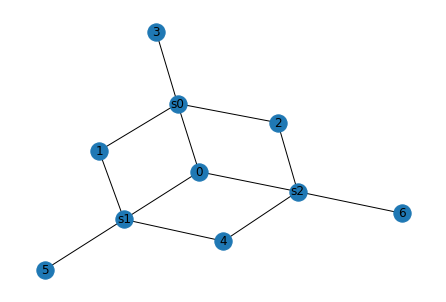

[0]


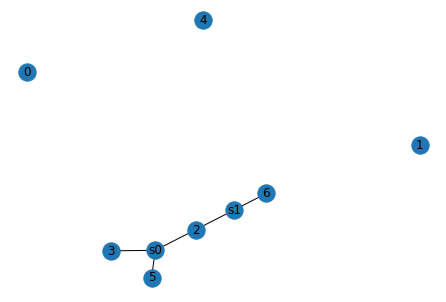

In [142]:
B = nx.Graph()
# B.add_nodes_from([1, 2, 3, 4], bipartite=0)
# B.add_nodes_from(["a", "b", "c"], bipartite=1)
# B.add_edges_from([(1, "a"), (1, "b"), (2, "b"), (2, "c"), (3, "c"), (4, "a")])
H = np.array([[1,1,1,1,0,0,0],\
              [1,1,0,0,1,1,0],\
              [1,0,1,0,1,0,1]])

N = 7 # number of data qubits
Ns = 3 # number of stabilizers
B.add_nodes_from(np.arange(N), bipartite=0)
B.add_nodes_from(["s%d" % s for s in np.arange(Ns)], bipartite=1)
for row in range(np.size(H,0)):
    qs = np.argwhere(H[row,:]>0)[:,0]
    B.add_edges_from([("s%d" % row, q) for q in qs])
    # print(qs)

color_dict = {0:'b',1:'r'}
color_list = [color_dict[i[1]] for i in B.nodes.data('bipartite')]

nx.draw(B,  with_labels=True, node_color = color_list)
plt.show()

# print([n for n in B.neighbors(1)])
p = 0.2
loss_inds = [0]#np.argwhere(np.random.rand(N)<p)[:,0]
print(loss_inds)

# remain_inds = np.array(list(set(np.arange(N))-set(loss_inds)))
# Sx_red, qubits_to_plot = compute_eff_Sx(H,loss_inds,remain_inds)
# print(Sx_red)
# print(qubits_to_plot)

for q in loss_inds:
    sq = [n for n in B.neighbors(q)]
    if len(sq)==1:
        # print(sq[0])
        B.remove_nodes_from(sq)
    # elif len(sq)==2:
    #     # print(sq)
    #     n0 = set(B.neighbors(sq[0]))
    #     n1 = set(B.neighbors(sq[1]))
    #     double_edgs = list(n0.intersection(n1))
    #     B.remove_edges_from([(sq[0],e) for e in double_edgs])
    #     B.remove_edges_from([(sq[1],e) for e in double_edgs])
    #     B = nx.contracted_nodes(B, sq[0], sq[1])
    else:
        double_edgs = []
        for i in range(len(sq)-1):
        # print(sq)
            n0 = set(B.neighbors(sq[i]))
            n1 = set(B.neighbors(sq[i+1]))
            double_edgs += [(sq[i], e) for e in list(n0.intersection(n1))]
            double_edgs += [(sq[i+1], e) for e in list(n0.intersection(n1))]
            # B.remove_edges_from([(sq[0],e) for e in double_edgs])
            # B.remove_edges_from([(sq[1],e) for e in double_edgs])
            # B = nx.contracted_nodes(B, sq[0], sq[1])
        # nx.contracted_nodes()
        B.remove_edges_from(double_edgs)
        for i in range(len(sq)-1):
            B = nx.contracted_nodes(B, sq[i], sq[i+1])
            
# print(double_edgs)
# color_dict = {0:'b',1:'r'}
# color_list = [color_dict[i[1]] for i in B.nodes.data('bipartite')]
nx.draw(B,  with_labels=True)#, node_color = color_list)
plt.show()

In [161]:
# RB_top = [n for n, d in B.nodes(data=True) if d["bipartite"] == 1]
# print(RB_top)
for n in B.nodes():
    # print(n,type(n))
    if isinstance(n, str):
        print(n)

s0
s1


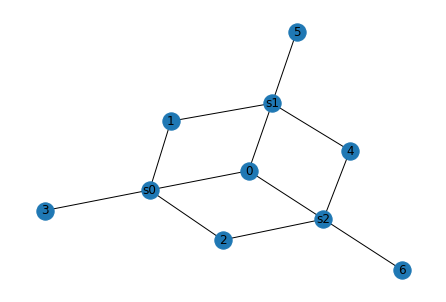

[1 4]
log op =  [[0. 0. 0. 0. 1. 1. 1.]]
[[0. 0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1.]]


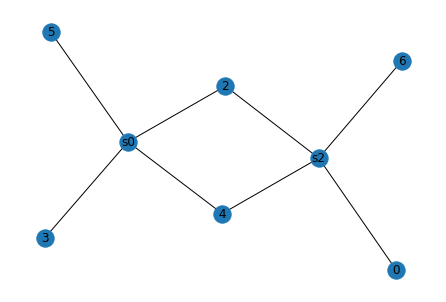

log op =  [[0. 0. 1. 1. 0. 0. 1.]]
[[1. 0. 0. 1. 0. 1. 1.]]


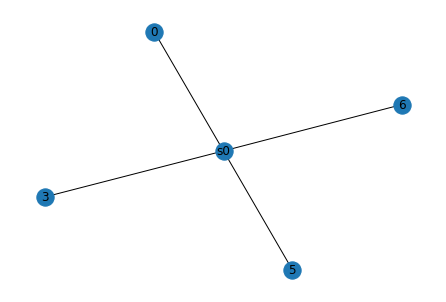

In [112]:
H = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

N = 7 # number of data qubits
Ns = 3 # number of stabilizers
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(H,0)):
    qs = np.argwhere(H[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])
    # print(qs)
# adj_mat = np.zeros((N+Ns,N+Ns))
# adj_mat[N:,:N] = H
# adj_mat += adj_mat.T
# B_orig = nx.from_numpy_matrix(adj_mat)

# adj_mat = nx.to_numpy_matrix(B_orig)
# print(adj_mat)
nx.draw(B_orig,  with_labels=True)#, node_color = color_list)
plt.show()

p = 0.3
loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
print(loss_inds)


B = B_orig.copy()
s_nodes_set = set(np.copy(s_nodes))
# q_nodes_set = list(set(np.arange(N))-set(loss_inds))

Ns_remain = len(s_nodes_set)
q_remain = list(set(B.nodes())-s_nodes_set)
node_list = list(s_nodes_set) + q_remain
adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

logical = np.ones(N)

for q in loss_inds:
    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
    if len(st_ind)>0:
        logical = (logical+Sx_mat[st_ind[0],:]) % 2
        print("log op = ", logical)
    else:
        break
    if Ns_remain == 0:
        break
    if q in B:
        sq = [n for n in B.neighbors(q)]
        if len(sq)==1:
            B.remove_nodes_from(sq)
            s_nodes_set -= set(sq)
        elif len(sq)>1:
            double_edgs = []
            for i in range(len(sq)-1):
                n0 = set(B.neighbors(sq[i]))
                n1 = set(B.neighbors(sq[i+1]))
                rep_qs = n0.intersection(n1)
                q0 = list(set(n0)-rep_qs)
                q1 = list(set(n1)-rep_qs)
                double_edgs += [(sq[i], e) for e in q0]
                double_edgs += [(sq[i], e) for e in q1]
            G = nx.Graph()
            G.add_nodes_from(sq[:-1])
            G.add_edges_from(double_edgs)
            sq_remain = list(s_nodes_set-set(sq))
            for s in sq_remain:
                G.add_edges_from([(s, e) for e in B.neighbors(s)])
            B = G
            s_nodes_set -= {sq[-1]}
        
        Ns_remain = len(s_nodes_set)
        if Ns_remain> 0:
            q_remain = list(set(B.nodes())-s_nodes_set)
            node_list = list(s_nodes_set) + q_remain
            adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
            Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
            keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,1]
            Sx_red = Sx_red[:,keep_cols]
            q_remain = np.array(q_remain)[keep_cols]
            Sx_mat = np.zeros((Ns_remain,N))
            Sx_mat[:,q_remain] = Sx_red
        else:
            Sx_mat = []
            
        print(Sx_mat)
            # print(s_nodes_set,q_remain)

    nx.draw(B,  with_labels=True)
    plt.show()

 # N_nodes = len(B.nodes())   
# Ns_remain = len(s_nodes_set)
# if Ns_remain> 0:
#     q_remain = list(set(B.nodes())-s_nodes_set)
#     node_list = list(s_nodes_set) + q_remain
#     # print(q_remain, s_nodes_set, node_list)
#     # print(nx.to_numpy_matrix(B, nodelist = node_list))
#     adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
#     # print(adj_mat_new)
#     # S = np.zeros((Ns_remain,len(q_remain)))
#     Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
#     # print(Sx_red)
#     keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,1]
#     # print(keep_cols)
#     Sx_red = Sx_red[:,keep_cols]
#     q_remain = np.array(q_remain)[keep_cols]
#     print(Sx_red)
#     print(s_nodes_set,q_remain)

# nx.draw(B,  with_labels=True)
# plt.show()

## single layer

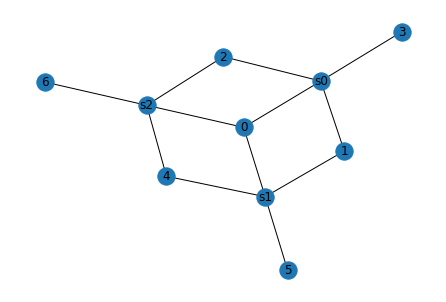

In [46]:
H = np.array([[1,1,1,1,0,0,0],\
              [1,1,0,0,1,1,0],\
              [1,0,1,0,1,0,1]])

N = 7 # number of data qubits
Ns = 3 # number of stabilizers
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(H,0)):
    qs = np.argwhere(H[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])
    # print(qs)

# color_dict = {0:'b',1:'r'}
# color_list = [color_dict[i[1]] for i in B.nodes.data('bipartite')]

nx.draw(B_orig,  with_labels=True)#, node_color = color_list)
plt.show()

# # print([n for n in B.neighbors(1)])
p_list = np.linspace(0.01,0.99,20)
Nrep = 2000
succ_prob = np.zeros(len(p_list))

for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
        # loss_inds = np.random.choice(N, 3, replace=False)
        # print(loss_inds)
        B = B_orig.copy()
        s_nodes_set = set(np.copy(s_nodes))
        for q in loss_inds:
            if q in B:
                sq = [n for n in B.neighbors(q)]
                if len(sq)==1:
                    # print(sq[0])
                    B.remove_nodes_from(sq)
                    s_nodes_set -= set(sq)
                elif len(sq)>1:
                    double_edgs = []
                    for i in range(len(sq)-1):
                    # print(sq)
                        n0 = set(B.neighbors(sq[i]))
                        n1 = set(B.neighbors(sq[i+1]))
                        rep_qs = n0.intersection(n1)
                        q0 = list(set(n0)-rep_qs)
                        q1 = list(set(n1)-rep_qs)
                        double_edgs += [(sq[i], e) for e in q0]
                        double_edgs += [(sq[i], e) for e in q1]
                        # double_edgs += [(sq[i], e) for e in rep_qs]
                        # double_edgs += [(sq[i+1], e) for e in rep_qs]
                        # B.remove_edges_from([(sq[0],e) for e in double_edgs])
                        # B.remove_edges_from([(sq[1],e) for e in double_edgs])
                        # B = nx.contracted_nodes(B, sq[0], sq[1])
                    # nx.contracted_nodes()
                    G = nx.Graph()
                    G.add_nodes_from(sq[:-1])
                    # for i in range(len(sq)-1):
                    G.add_edges_from(double_edgs)
                    sq_remain = list(s_nodes_set-set(sq))
                    for s in sq_remain:
                        G.add_edges_from([(s, e) for e in B.neighbors(s)])
                    B = G
                    s_nodes_set -= {sq[-1]}
                    # print(B.nodes())
                # print(double_edgs)
                # G.remove_edges_from(double_edgs)
            # nx.draw(B,  with_labels=True)#, node_color = color_list)
        # plt.show()
        # nx.draw(B,  with_labels=True)#, node_color = color_list)
        # plt.show()
        for sn in s_nodes:
            if sn in B:
                succ_prob[i_p] += 1
                # print(loss_inds)
                break
    # nx.draw(B,  with_labels=True)#, node_color = color_list)
    # plt.show()
succ_prob /= Nrep
# for n in B.nodes():
#     if isinstance(n, str):
#         Ns_remain[i_rep] += 1
#         break

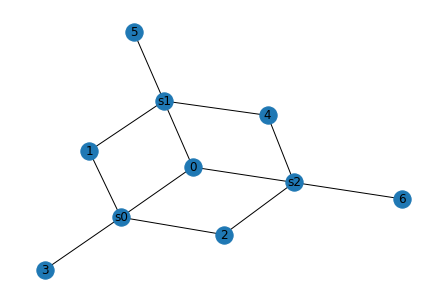

In [126]:
## with logical operator

H = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

N = 7 # number of data qubits
Ns = 3 # number of stabilizers
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(H,0)):
    qs = np.argwhere(H[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)#, node_color = color_list)
plt.show()

p_list = np.linspace(0.01,0.99,20)
Nrep = 2000
succ_prob = np.zeros(len(p_list))

for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])

        B = B_orig.copy()
        s_nodes_set = set(np.copy(s_nodes))

        Ns_remain = len(s_nodes_set)
        q_remain = list(set(B.nodes())-s_nodes_set)
        node_list = list(s_nodes_set) + q_remain
        adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
        Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

        logical = np.ones(N)
        logic_succ = True
        for q in loss_inds:
            if Ns_remain == 0:
                break
            st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
            if len(st_ind)>0:
                logical = (logical+Sx_mat[st_ind[0],:]) % 2
            else:
                logic_succ = False
                break
            if q in B:
                sq = [n for n in B.neighbors(q)]
                if len(sq)==1:
                    B.remove_nodes_from(sq)
                    s_nodes_set -= set(sq)
                elif len(sq)>1:
                    double_edgs = []
                    for i in range(len(sq)-1):
                        n0 = set(B.neighbors(sq[i]))
                        n1 = set(B.neighbors(sq[i+1]))
                        rep_qs = n0.intersection(n1)
                        q0 = list(set(n0)-rep_qs)
                        q1 = list(set(n1)-rep_qs)
                        double_edgs += [(sq[i], e) for e in q0]
                        double_edgs += [(sq[i], e) for e in q1]
                    G = nx.Graph()
                    G.add_nodes_from(sq[:-1])
                    G.add_edges_from(double_edgs)
                    sq_remain = list(s_nodes_set-set(sq))
                    for s in sq_remain:
                        G.add_edges_from([(s, e) for e in B.neighbors(s)])
                    B = G
                    s_nodes_set -= {sq[-1]}

                Ns_remain = len(s_nodes_set)
                if Ns_remain> 0:
                    q_remain = list(set(B.nodes())-s_nodes_set)
                    node_list = list(s_nodes_set) + q_remain
                    adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                    Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,1]
                    Sx_red = Sx_red[:,keep_cols]
                    q_remain = np.array(q_remain)[keep_cols]
                    Sx_mat = np.zeros((Ns_remain,N))
                    Sx_mat[:,q_remain] = Sx_red
                else:
                    Sx_mat = []

        if Ns_remain > 0 and np.sum(logical)>0 and logic_succ:
            succ_prob[i_p] += 1
            
succ_prob /= Nrep

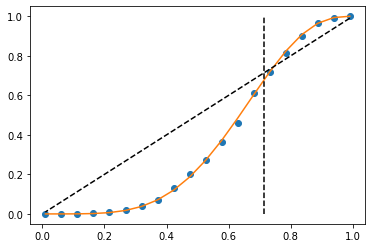

In [127]:
plt.plot(1-p_list,succ_prob,"o")
f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 #+ 7*5 *x**4 * (1-x)**3
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-2/7
plt.plot([x0,x0],[0,1],"k--")


In [50]:
def succ_prob_calc(B_orig,s_nodes, loss_inds):
    B = B_orig.copy()
    s_nodes_set = set(np.copy(s_nodes))
    for q in loss_inds:
        if q in B:
            sq = [n for n in B.neighbors(q)]
            if len(sq)==1:
                B.remove_nodes_from(sq)
                s_nodes_set -= set(sq)
            elif len(sq)>1:
                double_edgs = []
                for i in range(len(sq)-1):
                    n0 = set(B.neighbors(sq[i]))
                    n1 = set(B.neighbors(sq[i+1]))
                    rep_qs = n0.intersection(n1)
                    q0 = list(set(n0)-rep_qs)
                    q1 = list(set(n1)-rep_qs)
                    double_edgs += [(sq[i], e) for e in q0]
                    double_edgs += [(sq[i], e) for e in q1]
                G = nx.Graph()
                G.add_nodes_from(sq[:-1])
                G.add_edges_from(double_edgs)
                sq_remain = list(s_nodes_set-set(sq))
                for s in sq_remain:
                    G.add_edges_from([(s, e) for e in B.neighbors(s)])
                B = G
                s_nodes_set -= {sq[-1]}
    # nx.draw(B,  with_labels=True)
    # plt.show()
    succ_fail = 0
    for sn in s_nodes:
        if sn in B:
            succ_fail = 1
            break
    return succ_fail

## multi layer

In [ ]:
H = np.array([[1,1,1,1,0,0,0],\
              [1,1,0,0,1,1,0],\
              [1,0,1,0,1,0,1]])

N = 7 # number of data qubits
Ns = 3 # number of stabilizers
Nl = 2 # number of layers in foliated code
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N*Nl+Ns))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns*Nl)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(H,0)):
    qs = np.argwhere(H[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])
    # print(qs)

# color_dict = {0:'b',1:'r'}
# color_list = [color_dict[i[1]] for i in B.nodes.data('bipartite')]

nx.draw(B_orig,  with_labels=True)#, node_color = color_list)
plt.show()

